# Supervised Semantic Segmentation with a UNet for Sentinel-2 Satellite Imagery

Michael Mommert, Stuttgart University of Applied Sciences, 2025

This Notebook introduces the workflow for supervised learning with a UNet architecture. We will apply this model to Sentinel-2 satellite images from the [*ben-ge-800* dataset](https://zenodo.org/records/12941231) to perform pixel-wise classification (or semantic segmentation) based on land-use/land-cover data from the [ESAWorldCover dataset](https://esa-worldcover.org/en). This Notebook builds on the Notebook ["Supervised Classification with Deep Learning for Sentinel-2 Satellite Imagery"](https://github.com/Hochschule-fuer-Technik-Stuttgart/teaching-mommert/blob/main/classification/lulc_dl/lulc_dl.ipynb); please refer to that Notebook for additional explanations.

In [1]:
%pip install numpy \
    scipy \
    pandas \
    matplotlib \
    rasterio \
    scikit-learn \
    torch \
    torchmetrics \
    tqdm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.1/13.1 MB 6.0 MB/s eta 0:00:00a 0:00:01
Note: you may need to restart the kernel to use updated packages.


## Content

1. [Setting up the environment and data download](#setup)
2. [Data Inspection](#data_inspection)
3. [Data Handling](#data)
4. [Model Implementation](#model)
5. [Training and Validation Pipeline](#train-val)
6. [Hyperparameter Tuning](#hyperpars)
7. [Evaluation](#evaluation)
8. [Inference](#inference)


<a id='setup'></a>
## 1. Setup and Data Download

We're setting up our Python environment for this tutorial by installing and importing the necessary modules and packages:

In [1]:
# system level modules for handling files and file structures
import os
import tarfile
import copy

# scipy ecosystem imports for numerics, data handling and plotting
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl

# pytorch and helper modules
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchmetrics import JaccardIndex, F1Score

# utils
from tqdm.notebook import tqdm

# rasterio for reading in satellite image data
import rasterio as rio


We download the *ben-ge-800* dataset and unpack it:

In [ ]:
!wget https://zenodo.org/records/12941231/files/ben-ge-800.tar.gz?download=1 -O ben-ge-800.tar.gz
  
tarfile = tarfile.open('ben-ge-800.tar.gz')  # open ben-ge-800 tarball 
tarfile.extractall('./')  # extract tarball

**ben-ge-800** contains samples for 800 locations with co-located Sentinel-1 SAR data, Sentinel-2 multispectral data, elevation data, land-use/land-cover data, as well as environmental data. **ben-ge-800** is a subset of the much larger **ben-ge** dataset (see [https://github.com/HSG-AIML/ben-ge](https://github.com/HSG-AIML/ben-ge) for details.) We deliberately use a very small subset of **ben-ge** to enable reasonable runtimes for the examples shown in this tutorial.

The environment is now set up and the data in place. Before we define the dataset classes and dataloaders to access the data efficiently, we fix some random seeds to obtain reproduceable results:

In [3]:
np.random.seed(42)     # sets the seed value in Numpy
torch.manual_seed(42)  # sets the seed value in Pytorch\
torch.cuda.manual_seed(42)

<a id='data'></a>
## 2. Data Handling

We use the same dataset class that we implemented in the  Notebook ["Supervised Classification with Deep Learning for Sentinel-2 Satellite Imagery"](https://github.com/Hochschule-fuer-Technik-Stuttgart/teaching-mommert/blob/main/classification/lulc_dl/lulc_dl.ipynb). The class combines data access methods for the input data and ground-truth labels. 

Before we define the dataset class, we define some lists that we will need later.

In [ ]:
# define ESA WorldCover colormap
COLOR_CATEGORIES = [
    (0, 100, 0),
    (255, 187, 34),
    (255, 255, 76),
    (240, 150, 255),
    (250, 0, 0),
    (180, 180, 180),
    (240, 240, 240),
    (0, 100, 200),
    (0, 150, 160),
    (0, 207, 117),
    (250, 230, 160)]
cmap_all = mpl.colors.ListedColormap(np.array(COLOR_CATEGORIES)/255.)

# class label names
ewc_label_names = ["tree_cover", "shrubland", "grassland", "cropland", "built-up",
                   "bare/sparse_vegetation", "snow_and_ice","permanent_water_bodies",
                   "herbaceous_wetland", "mangroves","moss_and_lichen"]

class BENGE(Dataset):
    """A dataset class implementing the Sentinel-1, Sentinel-2 and ESAWorldCover data modalities."""
    def __init__(self, 
                 data_dir=data_base_path, 
                 split='train',
                 s2_bands=[2, 3, 4, 8]):
        """Dataset class constructor

        keyword arguments:
        data_dir -- string containing the path to the base directory of ben-ge dataset, default: ben-ge-800 directory
        split    -- string, describes the split to be instantiated, either `train`, `val` or `test`
        s2_bands -- list of Sentinel-2 bands to be extracted, default: all bands

        returns:
        BENGE object
        """
        super(BENGE, self).__init__()

        # store some definitions
        self.s2_bands = s2_bands
        self.data_dir = data_dir

        # read in relevant data files and definitions
        self.name = self.data_dir.split("/")[-1]
        self.split = split
        self.meta = pd.read_csv(f"{self.data_dir}/{self.name}_meta.csv", index_col='patch_id')

        # we shuffle the indices in the meta file and then select the first 500 samples for training, 150 for validation and 150 for testing
        self.meta.sample(frac=1).reset_index(drop=True)
        if split == 'train':
            self.meta = self.meta.iloc[0:500]
        if split == 'val':
            self.meta = self.meta.iloc[500:650]
        if split == 'test':
            self.meta = self.meta.iloc[650:800]
        self.meta = self.meta.loc[self.meta.split == split, :]  # filter by split

        split_df = pd.read_csv('ben-ge_{}.csv'.format(split), header=None, names=['patch_id'])
        self.meta = self.meta.loc[split_df.patch_id.values, :] 
        

    def __getitem__(self, idx):
        """Return sample `idx` as dictionary from the dataset."""
        sample_info = self.meta.iloc[idx]
        patch_id = self.meta.index[idx]
                
        # retrieve Sentinel-2 data
        s2 = np.empty((4, 120, 120))
        for i, band in enumerate(self.s2_bands):
            with rio.open(f"{self.data_dir}/sentinel-2/{patch_id}/{patch_id}_B0{band}.tif") as dataset:
                data = dataset.read(1)
            if i < 3:
                s2[i,:,:] = data/3000  # normalize Sentinel-2 data
            else:
                s2[i,:,:] = data/6000  # normalize Sentinel-2 data

        # extract lulc data
        with rio.open(f"{self.data_dir}/esaworldcover/{patch_id}_esaworldcover.tif") as dataset:
            ewc_data = dataset.read(1)
        ewc_mask = ewc_data.astype(float)   
        ewc_mask[ewc_mask == 100] = 110  # fix some irregular class labels
        ewc_mask[ewc_mask == 95] = 100   # fix some irregular class labels
        ewc_mask = ewc_mask / 10 - 1 # transform to scale [0, 11]

        # create sample dictionary containing all the data
        sample = {
            #"patch_id": patch_id,  # Sentinel-2 id of this patch
            "s2": torch.from_numpy(s2).float(),  # Sentine;-2 data [4, 120, 120]
            "lulc": torch.from_numpy(ewc_mask).long(),  # ESA WorldCover lulc classes per pixel [120, 120]
            }

        return sample

    def __len__(self):
        """Return length of this dataset."""
        return self.meta.shape[0]

    def display(self, idx, pred=None):
        """Method to display a data sample, consisting of the Sentinel-2 image and lulc map, and potentially a corresponding prediction.
        
        positional arguments:
        idx -- sample index
        
        keyword arguments:
        pred -- prediction tensor
        """

        # retrieve sample
        sample = self[idx]

        if pred is None:
            f, ax = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(8, 4))
        else:
            f, ax = plt.subplots(1, 3, sharex=True, sharey=True, figsize=(12, 4))

        # display Sentinel-2 image
        img_rgb = np.dstack(sample['s2'][0:3].numpy()[::-1])  # extract RGB, reorder, and perform a deep stack (shape: 120, 120, 3)
        img_rgb = np.clip((img_rgb-np.percentile(img_rgb, 1))/(np.percentile(img_rgb, 99)-np.percentile(img_rgb, 1)), 0, 1)
        ax[0].imshow(img_rgb)
        ax[0].set_title('Sentinel-2')
        ax[0].axis('off')

        # display lulc map
        ax[1].imshow(sample['lulc'], cmap=cmap_all, vmin=0, vmax=11, interpolation='nearest')
        ax[1].set_title('LULC')
        ax[1].axis('off')

        # display prediction, if available
        if pred is not None:
            ax[2].imshow(pred, cmap=cmap_all, vmin=0, vmax=11, interpolation='nearest')
            ax[2].set_title('Prediction')
            ax[2].axis('off')


We can now instantiate the different splits for this dataset:

In [67]:
train_data = BENGE(split='train')
val_data = BENGE(split='val')
test_data = BENGE(split='test')

len(train_data), len(val_data), len(test_data)

(472262, 59032, 59032)

We display a single sample from our dataset:

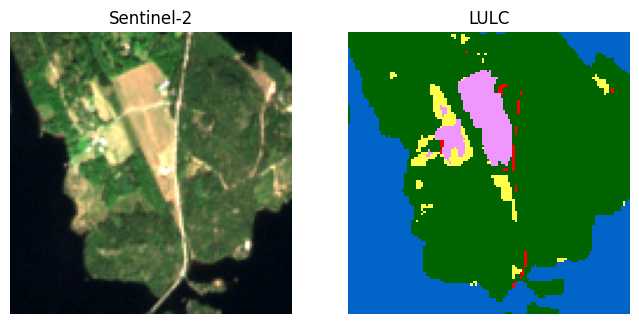

In [69]:
train_data.display(2)

For Neural Network training we have to define data loaders. When we do so, we have to define the batch size, which is typically limited by the GPU RAM during training. For evaluation purposes, we can typically pick a larger batch size, since we need less memory.

In [ ]:
train_batchsize = 64
eval_batchsize = 512

def collate_fn(batch):
    """This function combines the individual samples in a batch into the right format."""
    return {'s2': torch.stack([x['s2'] for x in batch]),
            'lulc': torch.stack([x['lulc'] for x in batch])}

train_dataloader = DataLoader(train_data, batch_size=train_batchsize, num_workers=4, pin_memory=True, collate_fn=collate_fn)
val_dataloader = DataLoader(val_data, batch_size=eval_batchsize, num_workers=4, pin_memory=True, collate_fn=collate_fn)
test_dataloader = DataLoader(test_data, batch_size=eval_batchsize, num_workers=4, pin_memory=True, collate_fn=collate_fn)

<a id='model'></a>
## 4. Model Implementation

UNet!!!!

This exact implementation has been adopted from https://github.com/milesial/Pytorch-UNet

In [ ]:
class DoubleConv(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""

    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            #nn.LeakyReLU(negative_slope=0.3, inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
            #nn.LeakyReLU(negative_slope=0.3, inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)


class Down(nn.Module):
    """Downscaling with maxpool then double conv"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)


class Up(nn.Module):
    """Upscaling then double conv"""

    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()

        # if bilinear, use the normal convolutions to reduce the number of channels
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
        else:
            self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        # if you have padding issues, see
        # https://github.com/HaiyongJiang/U-Net-Pytorch-Unstructured-Buggy/commit/0e854509c2cea854e247a9c615f175f76fbb2e3a
        # https://github.com/xiaopeng-liao/Pytorch-UNet/commit/8ebac70e633bac59fc22bb5195e513d5832fb3bd
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)


class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)


class UNet(nn.Module):
    def __init__(self, n_channels, n_classes, bilinear=False):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear

        self.inc = (DoubleConv(n_channels, 64))
        self.down1 = (Down(64, 128))
        self.down2 = (Down(128, 256))
        self.down3 = (Down(256, 512))
        factor = 2 if bilinear else 1
        self.down4 = (Down(512, 1024 // factor))
        self.up1 = (Up(1024, 512 // factor, bilinear))
        self.up2 = (Up(512, 256 // factor, bilinear))
        self.up3 = (Up(256, 128 // factor, bilinear))
        self.up4 = (Up(128, 64, bilinear))
        self.outc = (OutConv(64, n_classes))

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        return logits


model = UNet(n_channels=4, n_classes=12)

<a id='train-val'></a>
## 5. Training and Validation

First of all, let's verify if a GPU is available on our compute machine. If not, the CPU will be used instead.

In [72]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

print('Device used: {}'.format(device))

Device used: cuda:0


Before we can implement the training pipeline we have to define two more things: a Loss function and an optimizer that will update our model weights during training. We also define our evaluation metric, for which we use the accuracy score.

In [73]:
# we will use the cross entropy loss
criterion = nn.CrossEntropyLoss()

# we will use the Adam optimizer
learning_rate = 0.001
opt = optim.Adam(params=model.parameters(), lr=learning_rate)

# we instantiate the iou metric
iou = JaccardIndex(task="multiclass", num_classes=12).to(device)
f1 = F1Score(task="multiclass", num_classes=12).to(device)

Now, we have to move the model and the loss function on the GPU, since the computationally heavy work will be conducted there.

In [74]:
model.to(device)
criterion.to(device)
iou.to(device)

MulticlassJaccardIndex()

Finally, we can implement our training pipeline.


In [75]:
epochs = 5 

train_losses_epochs = []
val_losses_epochs = []
train_ious_epochs = []
val_ious_epochs = []
train_f1_epochs = []
val_f1_epochs = []

for ep in range(epochs):

    train_losses = []
    val_losses = []
    train_ious = []
    val_ious = []
    train_f1 = []
    val_f1 = []

    # we perform training for one epoch
    model.train()   # it is very important to put your model into training mode!
    for samples in (pbar := tqdm(train_dataloader)):
        # we extract the input data (Sentinel-2)
        x = samples['s2'].to(device)

        # now we extract the target (lulc class) and move it to the gpu
        y = samples['lulc'].to(device)
       
        # we make a prediction with our model
        output = model(x)
        
        # we reset the graph gradients
        model.zero_grad()

        # we determine the classification loss
        loss_train = criterion(output, y)

        # we run a backward pass to comput the gradients
        loss_train.backward()

        # we update the network paramaters
        opt.step()

        # we write the mini-batch loss and accuracy into the corresponding lists
        train_losses.append(loss_train.detach().cpu())
        train_ious.append(iou(torch.argmax(output, dim=1), y).detach().cpu())
        train_f1.append(f1(torch.argmax(output, dim=1), y).detach().cpu())
        
        pbar.set_description("loss={:.4f}, iou={:.4f}, f1={:.4f}".format(train_losses[-1], train_ious[-1], train_f1[-1]))

    # we evaluate the current state of the model on the validation dataset
    model.eval()   # it is very important to put your model into evaluation mode!
    with torch.no_grad():
        for samples in tqdm(val_dataloader):
            # we extract the input data (Sentinel-2)
            x = samples['s2'].to(device)

            # now we extract the target (lulc class) and move it to the gpu
            y = samples['lulc'].to(device)
             
            # we make a prediction with our model
            output = model(x)

            # we determine the classification loss
            loss_val = criterion(output, y)

            # we write the mini-batch loss and accuracy into the corresponding lists
            val_losses.append(loss_val.detach().cpu())
            val_ious.append(iou(torch.argmax(output, dim=1), y).detach().cpu())
            val_f1.append(f1(torch.argmax(output, dim=1), y).detach().cpu())
    
    train_losses_epochs.append(np.mean(train_losses))
    train_ious_epochs.append(np.mean(train_ious))
    train_f1_epochs.append(np.mean(train_f1))
    val_losses_epochs.append(np.mean(val_losses))
    val_ious_epochs.append(np.mean(val_ious))
    val_f1_epochs.append(np.mean(val_f1))
    
    print("epoch {}: train: loss={:.4f}, iou={:.4f}, f1={:.4f}; val: loss={:.4f}, iou={:.4f}, f1={:.4f}".format(
        ep, train_losses_epochs[-1], train_ious_epochs[-1], train_f1_epochs[-1], 
        val_losses_epochs[-1], val_ious_epochs[-1], val_f1_epochs[-1]))

  0%|          | 0/7380 [00:00<?, ?it/s]

  0%|          | 0/116 [00:00<?, ?it/s]

epoch 0: train: loss=0.4527, iou=0.4130, f1=0.8271; val: loss=0.4216, iou=0.4152, f1=0.8366


  0%|          | 0/7380 [00:00<?, ?it/s]

KeyboardInterrupt: 

Training progress looks good: train and validation losses are decreasing, accuracies are increasing.

Let's plot the available metrics as a function of the number of training iterations:

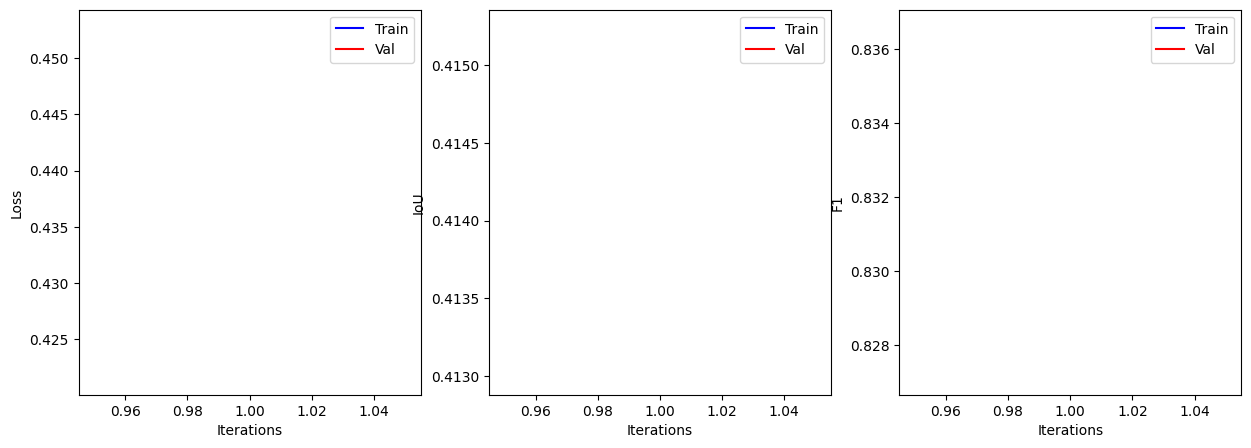

In [76]:
f, ax = plt.subplots(1, 3, sharex=True, figsize=(15,5))

ax[0].plot(np.arange(1, len(train_losses_epochs)+1), train_losses_epochs, label='Train', color='blue')
ax[0].plot(np.arange(1, len(val_losses_epochs)+1), val_losses_epochs, label='Val', color='red')
ax[0].set_xlabel('Iterations')
ax[0].set_ylabel('Loss')
ax[0].legend()

ax[1].plot(np.arange(1, len(train_ious_epochs)+1), train_ious_epochs, label='Train', color='blue')
ax[1].plot(np.arange(1, len(val_ious_epochs)+1), val_ious_epochs, label='Val', color='red')
ax[1].set_xlabel('Iterations')
ax[1].set_ylabel('IoU')
ax[1].legend()

ax[2].plot(np.arange(1, len(train_f1_epochs)+1), train_f1_epochs, label='Train', color='blue')
ax[2].plot(np.arange(1, len(val_f1_epochs)+1), val_f1_epochs, label='Val', color='red')
ax[2].set_xlabel('Iterations')
ax[2].set_ylabel('F1')
ax[2].legend()

We see how the losses drop and the accuracy increases for both the training and validation dataset. Since the validation metrics follow the training metrics, we do not see any obvious signs for overfitting. Based on the validation dataset, we reach an accuracy of 47% for our multi-class classification problem.

<a id='hyperpars'></a>
## 6. Hyperparameter Tuning

We trained the model successfully. But did we manage to get the best possible result?

In order to find out, we have to perform hyperparameter tuning. The only obvious hyperparameter of our model is the learning rate. Architectural considerations can also be considered as hyperparameters, but we will keep our architecture fixed.

As a result, we only have to tune the learning rate. We could try other learning rate values, such as 0.01 or 0.0001, or use a scheduler that modifies the learning rate as a function of the training progress.

However, we will skip this tuning process here to save some time. Instead, we will use the trained model "as is".



<a id='evaluation'></a>
## 7. Evaluation

After finishing the hyperparameter tuning, we can perform the final evaluation of our model. We will again use the accuracy metric, but could easily replace it or add additional metrics.

To properly evaluate our model we must use the test dataset in the evaluation process. Since the model has never seen the test dataset before, it will provide a realistic estimate of the performance of the model on previously unseen data.

The evaluation uses more or less the same code that we used to evaluate our model during training.

In [77]:
test_ious = []
test_f1 = []
predictions = []
groundtruths = []

model.eval()   # it is very important to put your model into evaluation mode!
with torch.no_grad():
    for samples in tqdm(test_dataloader):
        x = samples['s2'].to(device)

        # now we extract the target (lulc class) and move it to the gpu
        y = samples['lulc'].to(device)
        groundtruths.append(y.cpu())

        # we make a prediction with our model
        output = model(x)
        predictions.append(np.argmax(output.cpu().numpy(), axis=1))
        
        # we determine the classification loss
        loss_val = criterion(output, y)

        # we write the mini-nbatch loss and accuracy into the corresponding lists
        test_ious.append(iou(torch.argmax(output, dim=1), y).cpu().numpy())
        test_f1.append(f1(torch.argmax(output, dim=1), y).cpu().numpy())


print('test dataset ious:', np.mean(test_ious))
print('test dataset f1:', np.mean(test_f1))

# flatten predictions and groundtruths
predictions = np.concatenate(predictions).ravel()
groundtruths = np.concatenate(groundtruths).ravel()


  0%|          | 0/116 [00:00<?, ?it/s]

KeyboardInterrupt: 

The test dataset accuracy is 50%, which is even higher than the validation accuracy.

**Question**: Don't get fooled by the accuracy. The model performs not too badly. What is the baseline accuracy you would expect for for random guessing in a multi-class classification problem, if there are 11 different classes?

Now, let's also have a look at the performance on a per-class basis via the confusion matrix:

In [ ]:
f, ax = plt.subplots(1, 1, figsize=(8,6))

# plot the confusion matrix
disp = ConfusionMatrixDisplay.from_predictions(
    groundtruths, predictions,
    display_labels=[ewc_label_names[i] for i in np.unique(groundtruths)],
    normalize='true',
    ax=ax)
# note that not all classes are present in the test dataset

# rotate x labels for better readability
ax.set_xticks(ax.get_xticks(), ax.get_xticklabels(), rotation=90)

The confusion matrix reveals a few limitations of our trained model:
* the model is unable to predict some of the classes (e.g., shrubland, cropland and bare/sparse vegeation; and it is bad at predicting built-up areas)
* the model is very good at identifying water surfaces
* there is significant confusion between a number of classes (e.g., a variety of classes are confused with tree cover and grassland)

**Question**: What are the reasons for these limitations?

<a id='inference'></a>
## 8. Inference

Now that our model is trained and evaluated, we can use it to predict the most common land-use/land-cover class in an image patch.

Let's pick a random patch from our test dataset and run it through the model to perfom a prediction:

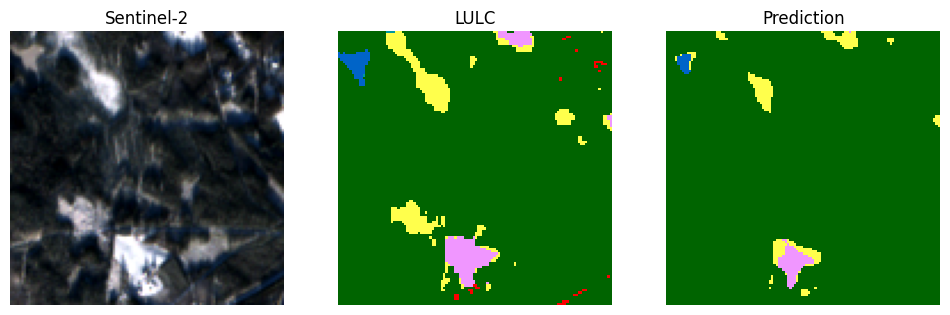

In [85]:
i = 1520

# we retrieve a random sample
sample = test_data[i]

input = sample['s2'].reshape(1, 4, 120, 120)
output = model(input.to(device))  # we have to change the shape of the input
prediction = torch.argmax(output, dim=1).reshape(120, 120).cpu().numpy()

# display prediction
test_data.display(i, pred=prediction)

The model gets the overall shapes right, but it fails to get the right classes in many cases.